In [12]:
import os.path as osp
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

cmap = plt.get_cmap("cubehelix")
indices = np.linspace(0, cmap.N, 10)
colors = [cmap(int(i)) for i in indices]

sys.path.insert(0, "../src/")

from post_simulation_utils import (
    plot_regret,
    plot_logloss,
    plot_confidence_interval,
    calc_performance_per_regret,
)


In [19]:
# Plot params
mpl.style.use("seaborn-dark")
mpl.rcParams["axes.grid"] = True
mpl.rcParams["legend.frameon"] = True
mpl.rcParams["figure.dpi"] = 85
mpl.rcParams["axes.labelsize"] = "large"
mpl.rcParams["lines.linestyle"] = "-."
mpl.rcParams["lines.marker"] = "o"
mpl.rcParams["lines.markersize"] = 2
mpl.rcParams["lines.linewidth"] = 1.8
w, h = plt.rcParams.get("figure.figsize")

# This is the largest possible value of the logloss
log_inf_limit = -np.log(np.finfo("float").eps)
log_inf_limit


36.04365338911715

# Load data

In [26]:
res_paths = [
    osp.join("..", "output", "real_data_bostonHousing_20201124_101101", "results.csv"),
    osp.join("..", "output", "real_data_bostonHousing_20201126_111146", "results.csv"),
    osp.join("..", "output", "real_data_concrete_20201124_111150", "results.csv"),
    osp.join("..", "output", "real_data_concrete_20201126_121127", "results.csv"),
    osp.join("..", "output", "real_data_energy_20201124_111115", "results.csv"),
    osp.join("..", "output", "real_data_energy_20201126_121136", "results.csv"),
    osp.join("..", "output", "real_data_kin8nm_20201124_121102", "results.csv"),
    osp.join("..", "output", "real_data_kin8nm_20201126_121146", "results.csv"),
    osp.join("..", "output", "real_data_naval-propulsion-plant_20201124_131134", "results.csv", ),
    osp.join("..", "output", "real_data_power-plant_20201124_161129", "results.csv"),
    osp.join("..", "output", "real_data_wine-quality-red_20201126_081100", "results.csv"),
    osp.join("..", "output", "real_data_yacht_20201124_171159", "results.csv"),
]




res_dfs = [pd.read_csv(res_path) for res_path in res_paths]


In [27]:
# Take the mean over experimetns
res_list = []
for i, res_df in enumerate(res_dfs):
    # Verify each df is for specific dataset
    dataset_name = res_df.dataset_name.unique()[0]
    print(f"{dataset_name}")

    # Filter samples that the pNML was not converged there from empirical reasons
    print(f'Failure: {np.sum(res_df["pnml_success"] == False)}')
    res_df = res_df[res_df["pnml_success"] == True]
    print(
        "Total {}. Inf regret {}. Inf logloss {}. empirical>analytical {}.".format(
            len(res_df),
            (res_df["pnml_regret"] >= log_inf_limit).sum(),
            (res_df["pnml_test_logloss"] >= log_inf_limit).sum(),
            (res_df["pnml_regret"] > res_df["analytical_pnml_regret"] + 1e-1).sum(),
        )
    )
#     res_df = res_df[res_df["trainset_size"] != res_df["num_features"] - 1]
    res_df = res_df[res_df["pnml_test_logloss"] < log_inf_limit]
    res_df = res_df[res_df["analytical_pnml_regret"] >= res_df["pnml_regret"]]

    print(f"Features={res_df.num_features.mean()}")
    print(f"Sizes={res_df.trainset_size.unique()}")
    mean_df = res_df.groupby("trainset_size").mean().reset_index()
    std_df = res_df.groupby("trainset_size").agg(np.std, ddof=0).reset_index()
    count_df = res_df.groupby("trainset_size").agg("count")
    res_dict = {
        "dataset_name": dataset_name,
        "mean_df": mean_df,
        "std_df": std_df,
        "count_df": count_df,
        "res_df": res_df.copy(),
    }
    res_list.append(res_dict)
    print()

bostonHousing
Failure: 165
Total 23295. Inf regret 0. Inf logloss 9. empirical>analytical 0.
Features=14.0
Sizes=[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  22  31  45  65
  94 136 196 283 409]

bostonHousing
Failure: 0
Total 23460. Inf regret 0. Inf logloss 14. empirical>analytical 0.
Features=14.0
Sizes=[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  22  31  45  65
  94 136 196 283 409]

concrete
Failure: 408
Total 36672. Inf regret 0. Inf logloss 3. empirical>analytical 0.
Features=9.0
Sizes=[  2   3   4   5   6   7   8   9  10  16  27  44  71 117 191 312 510 834]

concrete
Failure: 0
Total 37080. Inf regret 0. Inf logloss 4. empirical>analytical 0.
Features=9.0
Sizes=[  2   3   4   5   6   7   8   9  10  16  27  44  71 117 191 312 510 834]

energy
Failure: 383
Total 27337. Inf regret 0. Inf logloss 1. empirical>analytical 1.
Features=9.0
Sizes=[  2   3   4   5   6   7   8   9  10  16  25  40  63  99 157 248 393 621]

energy
Failure: 0
Total 27720. Inf regret

# Regret as a point wise confidence

In [ ]:
for i, res_dict in enumerate(res_list[0:2]):
    df = res_dict["res_df"]
    num_features = int(df.num_features.mean())
    dataset_name = res_dict["dataset_name"]
    print(dataset_name, num_features)
    for m in range(2, num_features):
        print(m)
        (
            regrets,
            counts,
            pnml_means,
            mn_means,
            cdf_means,
            pnml_stds,
            mn_stds,
            cdf_stds,
        ) = calc_performance_per_regret(df, num_features=m)

        fig, axs = plt.subplots(2, 1, sharex=True, figsize=(0.6 * w, 0.8 * h))
        ax = axs[0]
        ax.plot(regrets, mn_means, "-", label="Minimum norm", color="C0", alpha=0.6)
        plot_confidence_interval(ax, regrets, mn_means, mn_stds, counts, "C0")

        ax.plot(regrets, pnml_means, label="pNML", color="C1", alpha=0.6)
        plot_confidence_interval(ax, regrets, pnml_means, pnml_stds, counts, "C1")
        ax.set_ylabel("logloss")
        if i == 0:
            ax.legend(loc=4)
        ax.set_ylim(bottom=0.0, top=max(pnml_means.max(), mn_means.max()))
        ax.set_xlim(left=0.0)

        # CDF
        ax = axs[1]
        ax.plot(regrets, cdf_means, color="C1", alpha=0.6)
        plot_confidence_interval(ax, regrets, cdf_means, cdf_stds, counts, "C1")
        ax.set_yticks(np.linspace(0, 1, 6))
        ax.set_xlabel("pNML regret threshold")
        ax.set_ylabel("CDF")

        # Save and show
        plt.tight_layout()
        plt.savefig(f"../output/figures/regret_based_loss_{dataset_name}.pdf")
        plt.show()

# Double decent

bostonHousing


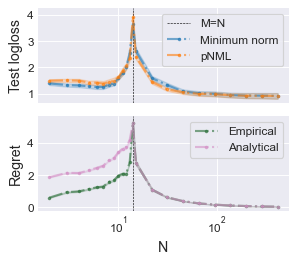

bostonHousing


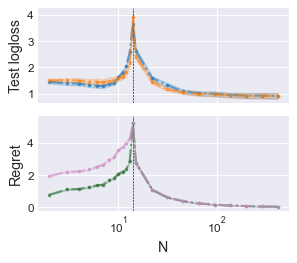

concrete


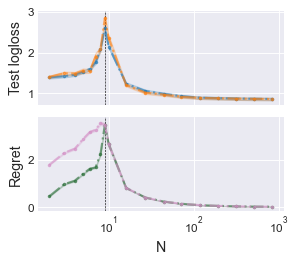

concrete


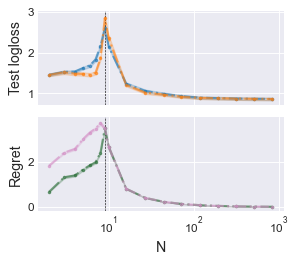

energy


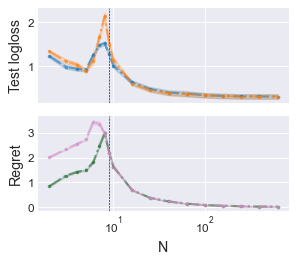

energy


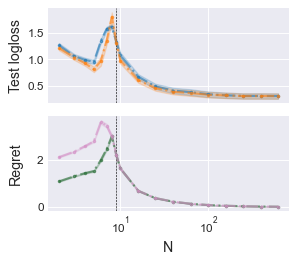

kin8nm


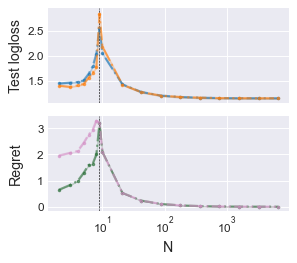

kin8nm


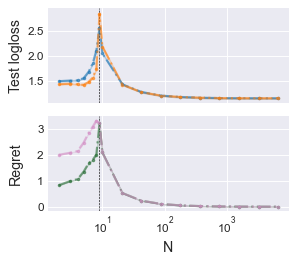

naval-propulsion-plant


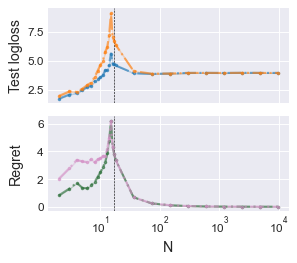

power-plant


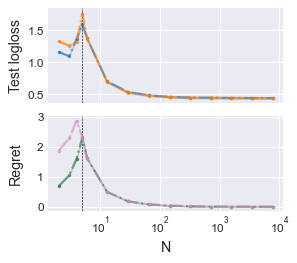

wine-quality-red


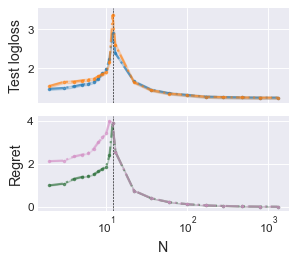

yacht


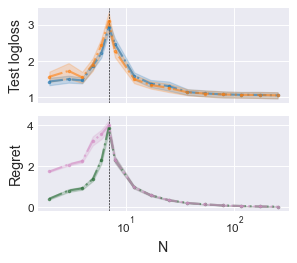

In [28]:
# Plot performance
for i, res_dict in enumerate(res_list):
    dataset_name = res_dict["dataset_name"]
    res_mean_df = res_dict["mean_df"]
    print(dataset_name)

    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(0.6 * w, 0.8 * h))
    axs[0].axvline(
        res_mean_df["num_features"].mean(),
        color="black",
        linewidth=0.5,
        linestyle="--",
        marker="",
        label="M=N",
    )
    axs[1].axvline(
        res_mean_df["num_features"].mean(), color="black", linewidth=0.5, linestyle="--", marker="",
    )

    ax = axs[0]
    plot_logloss(ax, res_dict)
    if i == 0:
        ax.legend(loc=1)
    ax.set_ylabel("Test logloss")

    ax = axs[1]
    plot_regret(ax, res_dict)

    if i == 0:
        ax.legend(loc=1)
    ax.set_ylabel("Regret")
    ax.set_xlabel("N")

    axs[0].set_xscale("symlog")
    #     axs[0].set_yscale("symlog")
    fig.align_ylabels(axs)
    plt.tight_layout()
    plt.savefig(f"../output/figures/real_data_{dataset_name}.pdf")
    plt.show()


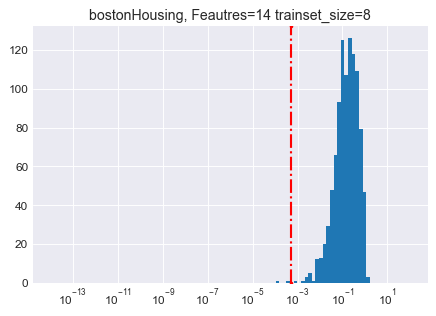

0.001984126984126984


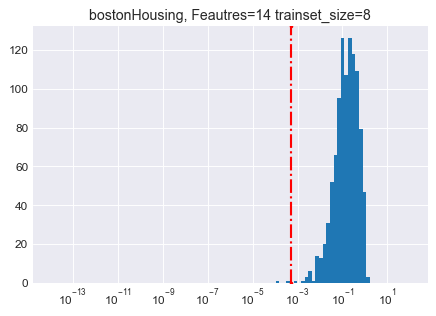

0.00196078431372549


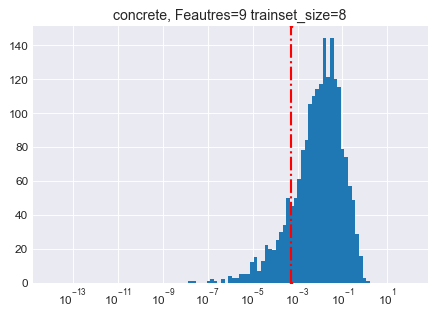

0.1437875751503006


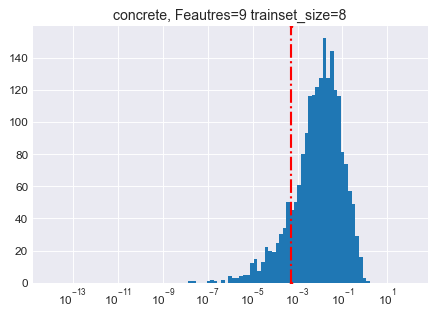

0.1389023797960175


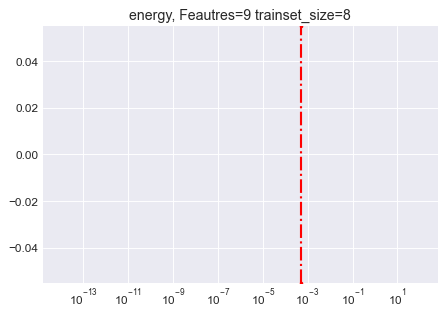

1.0


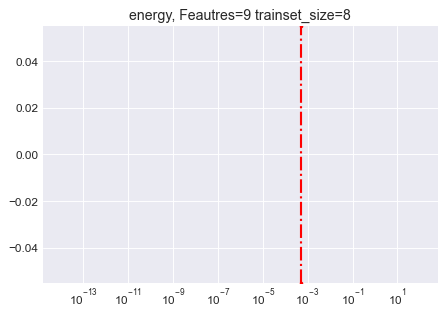

1.0


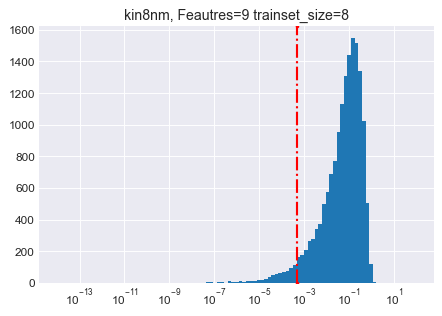

0.04587444227989694


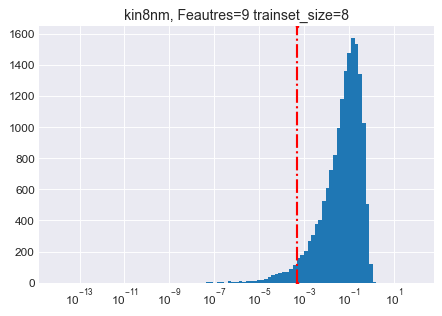

0.04462759462759463


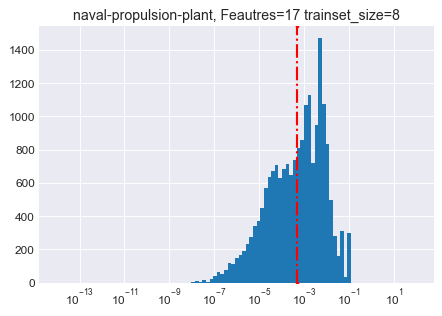

0.46388150002607836


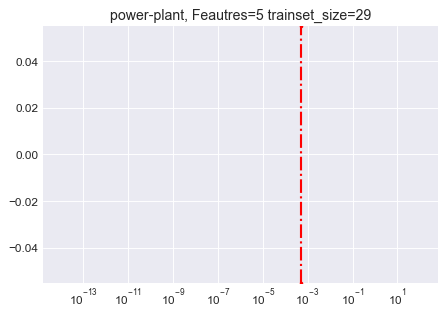

1.0


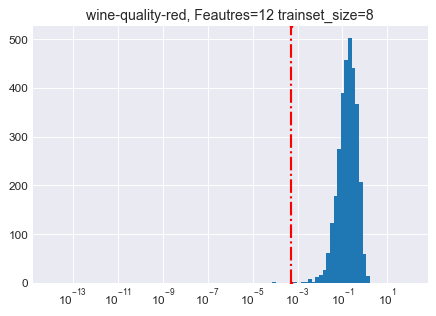

0.0028580501746586218


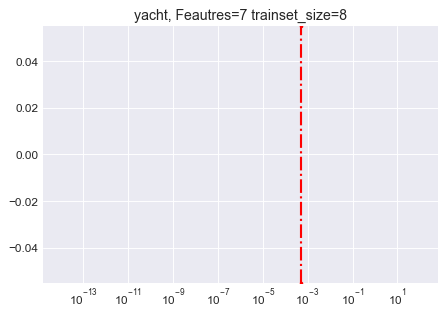

1.0


In [29]:
x_bot_square_thresh = 1e-3 / 2
for res_dict in res_list:
    res_df = res_dict["res_df"]
    trainset_sizes = res_df.trainset_size.unique()
    trainset_size = trainset_sizes[6]
    dataset_name = res_dict["dataset_name"]
    res_df = res_df[res_df["trainset_size"] == trainset_size]
    logbins = np.logspace(-14, 2, 100)
    plt.hist(res_df.x_bot_square, bins=logbins)
    plt.xscale("log")
    plt.axvline(x_bot_square_thresh, color="r")
    plt.title(
        "{}, Feautres={} trainset_size={}".format(
            dataset_name, int(res_df.num_features.mean()), trainset_size
        )
    )
    plt.show()

    print(np.sum(res_df.x_bot_square < x_bot_square_thresh) / len(res_df))

In [8]:
res_dict = res_list[0]
res_df,dataset_name= res_dict['res_df'],res_dict['dataset_name']
trainset_size = 10
trail_num= 0 
print(res_df.trainset_size.unique())
df = res_df[res_df.trainset_size == trainset_size]
print(df.columns)

[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  22  31  45  65
  94 136 196 283 409]
Index(['dataset_name', 'trainset_size', 'split', 'valset_size', 'testset_size',
       'num_features', 'mn_test_logloss', 'mn_test_mse', 'mn_theta_norm',
       'mn_variance', 'pnml_regret', 'pnml_test_logloss', 'pnml_variance',
       'pnml_success', 'pnml_norm_factors', 'x_bot_square', 'x_norm_square',
       'genie_test_logloss', 'analytical_pnml_regret', 'test_idx'],
      dtype='object')


In [9]:
df = df.sort_values(by='empirical_pnml_regret')
plt.plot(df.empirical_pnml_regret,df.empirical_pnml_test_logloss,'*')
plt.xlabel('regret')
plt.ylabel('logloss')

KeyError: 'empirical_pnml_regret'

In [ ]:
from scipy.stats import kde
nbins = 100
x,y = df.empirical_pnml_regret,df.empirical_pnml_test_logloss
data = np.array((x, y)).T

fig,ax = plt.subplots(1,1)

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
k = kde.gaussian_kde(data.T)
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 

# add shading
ax.set_title('2D Density with shading')
ax.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r)


In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")

# fig,ax = plt.subplots(1,1)
# sns.jointplot(data=df, x="empirical_pnml_regret", y="empirical_pnml_test_logloss",kind="kde")
# sns.jointplot(data=df, x="empirical_pnml_regret", y="mn_test_logloss",kind="kde")
# ax.set_ylim(top=10)
# plt.show()x

fig,ax = plt.subplots(1,1)
sns.kdeplot(data=df, x="empirical_pnml_regret", y="empirical_pnml_test_logloss", shade=True, cut=5, ax=ax)
sns.kdeplot(data=df, x="empirical_pnml_regret", y="mn_test_logloss", shade=True, cut=5, ax=ax,alpha=0.5)
ax.set_ylim(top=10)
plt.show()